# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


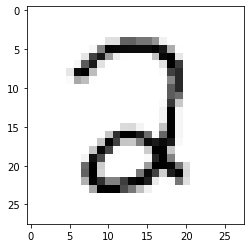

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2311
Training Accuracy: 0.7574, Testing Accuracy: 0.7686



Epoch 10, Loss 0.0629
Training Accuracy: 0.9372, Testing Accuracy: 0.9466



Epoch 20, Loss 0.0441
Training Accuracy: 0.9531, Testing Accuracy: 0.9607



Epoch 30, Loss 0.0369
Training Accuracy: 0.9601, Testing Accuracy: 0.9657



Epoch 40, Loss 0.0329
Training Accuracy: 0.9635, Testing Accuracy: 0.9688



Epoch 50, Loss 0.0303
Training Accuracy: 0.9663, Testing Accuracy: 0.9693



Epoch 60, Loss 0.0284
Training Accuracy: 0.9681, Testing Accuracy: 0.9698



Epoch 70, Loss 0.0269
Training Accuracy: 0.9695, Testing Accuracy: 0.9688



Epoch 80, Loss 0.0257
Training Accuracy: 0.9704, Testing Accuracy: 0.9713



Epoch 90, Loss 0.0246
Training Accuracy: 0.9720, Testing Accuracy: 0.9718



Epoch 100, Loss 0.0237
Training Accuracy: 0.9730, Testing Accuracy: 0.9733



Epoch 110, Loss 0.0229
Training Accuracy: 0.9745, Testing Accuracy: 0.9743



Epoch 120, Loss 0.0222
Training Accuracy: 0.9748, Testing Accuracy: 0.9743



Epoch 130, Loss 0.0215
Training Accuracy: 0.9759, Testing Accuracy: 0.9748



Epoch 140, Loss 0.0209
Training Accuracy: 0.9763, Testing Accuracy: 0.9758



Epoch 150, Loss 0.0203
Training Accuracy: 0.9772, Testing Accuracy: 0.9763



Epoch 160, Loss 0.0197
Training Accuracy: 0.9776, Testing Accuracy: 0.9758



Epoch 170, Loss 0.0192
Training Accuracy: 0.9782, Testing Accuracy: 0.9768



Epoch 180, Loss 0.0187
Training Accuracy: 0.9791, Testing Accuracy: 0.9773



Epoch 190, Loss 0.0182
Training Accuracy: 0.9794, Testing Accuracy: 0.9768



Epoch 200, Loss 0.0178
Training Accuracy: 0.9800, Testing Accuracy: 0.9773



Epoch 210, Loss 0.0173
Training Accuracy: 0.9809, Testing Accuracy: 0.9778



Epoch 220, Loss 0.0169
Training Accuracy: 0.9818, Testing Accuracy: 0.9778



Epoch 230, Loss 0.0165
Training Accuracy: 0.9823, Testing Accuracy: 0.9773



Epoch 240, Loss 0.0161
Training Accuracy: 0.9826, Testing Accuracy: 0.9783



0.03159256128588752

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.1984
Training Accuracy: 0.7813, Testing Accuracy: 0.7868



Epoch 10, Loss 0.1018
Training Accuracy: 0.9054, Testing Accuracy: 0.9158



Epoch 20, Loss 0.0795
Training Accuracy: 0.9253, Testing Accuracy: 0.9345



Epoch 30, Loss 0.0686
Training Accuracy: 0.9347, Testing Accuracy: 0.9415



Epoch 40, Loss 0.062
Training Accuracy: 0.9392, Testing Accuracy: 0.9466



Epoch 50, Loss 0.0574
Training Accuracy: 0.9445, Testing Accuracy: 0.9546



Epoch 60, Loss 0.0541
Training Accuracy: 0.9465, Testing Accuracy: 0.9567



Epoch 70, Loss 0.0515
Training Accuracy: 0.9483, Testing Accuracy: 0.9587



Epoch 80, Loss 0.0495
Training Accuracy: 0.9497, Testing Accuracy: 0.9597



Epoch 90, Loss 0.0478
Training Accuracy: 0.9513, Testing Accuracy: 0.9622



Epoch 100, Loss 0.0463
Training Accuracy: 0.9522, Testing Accuracy: 0.9632



Epoch 110, Loss 0.0451
Training Accuracy: 0.9530, Testing Accuracy: 0.9637



Epoch 120, Loss 0.044
Training Accuracy: 0.9539, Testing Accuracy: 0.9647



Epoch 130, Loss 0.0431
Training Accuracy: 0.9549, Testing Accuracy: 0.9652



Epoch 140, Loss 0.0423
Training Accuracy: 0.9551, Testing Accuracy: 0.9652



Epoch 150, Loss 0.0415
Training Accuracy: 0.9558, Testing Accuracy: 0.9657



Epoch 160, Loss 0.0408
Training Accuracy: 0.9564, Testing Accuracy: 0.9662



Epoch 170, Loss 0.0402
Training Accuracy: 0.9571, Testing Accuracy: 0.9662



Epoch 180, Loss 0.0397
Training Accuracy: 0.9582, Testing Accuracy: 0.9662



Epoch 190, Loss 0.0391
Training Accuracy: 0.9590, Testing Accuracy: 0.9667



Epoch 200, Loss 0.0387
Training Accuracy: 0.9592, Testing Accuracy: 0.9667



Epoch 210, Loss 0.0382
Training Accuracy: 0.9597, Testing Accuracy: 0.9672



Epoch 220, Loss 0.0378
Training Accuracy: 0.9601, Testing Accuracy: 0.9672



Epoch 230, Loss 0.0374
Training Accuracy: 0.9604, Testing Accuracy: 0.9677



Epoch 240, Loss 0.0371
Training Accuracy: 0.9608, Testing Accuracy: 0.9682



0.018336218732477764

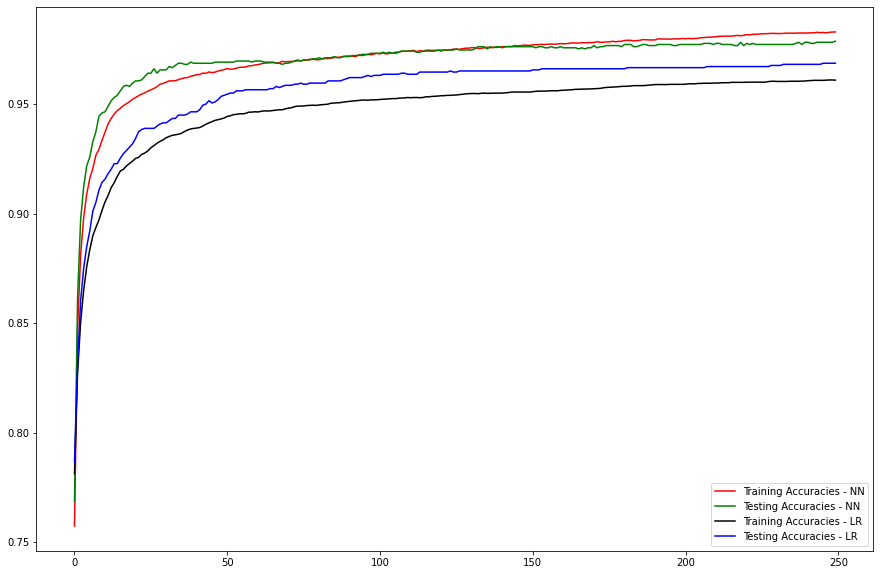

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

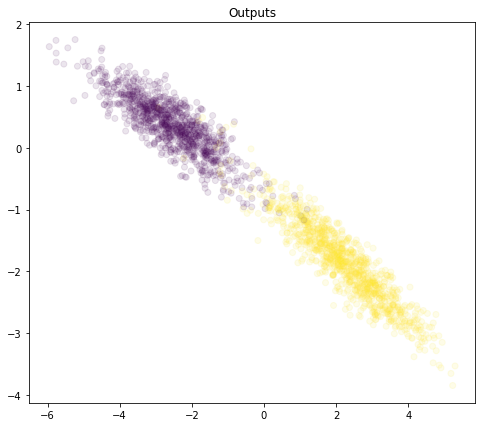

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

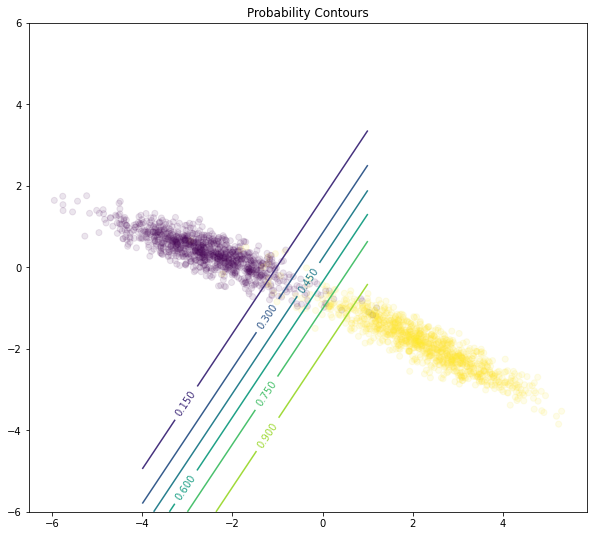

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );